##### Copyright 2019 The TensorFlow Authors.

# Credit: https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention
**Check above links for more exciting tutorial**

# Neural Machine Translation with Attention

This notebook trains a sequence to sequence (seq2seq) model for Hindi to English translation. This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, we will be able to input a Hindi sentence, such as **"तुम कहाँ गए थे?"**, and return the English translation: **"where did you go?"**



In [1]:
#https://stackoverflow.com/questions/7075082/what-is-future-in-python-used-for-and-how-when-to-use-it-and-how-it-works
#With __future__ module's inclusion, you can slowly be accustomed to incompatible changes or to such ones introducing new keywords.
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

#https://docs.python.org/2/library/unicodedata.html
import unicodedata
import re
import numpy as np
import os
import io
import time

TensorFlow 2.x selected.


## Download the dataset

I'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

I am gonna take hindi to english pair because i can understand it more easily if things are working right or wrong.


**I downloaded the dataset and put that into my drive and directly fetched it by calling get_file from keras**

In [2]:
# Download the file
#tf.keras.utils.get file download the file directly from url
#you can read more about this here
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file
path_to_zip = tf.keras.utils.get_file(
    'hin-eng.zip', origin='https://drive.google.com/accounts?authuser=1&continueUrl=https://drive.google.com/uc?authuser%3D1%26id%3D1YSxk17Dj6qwJAKbBqFbvPE3gBjQPe68X%26export%3Ddownload',
    extract=True)

#path_to_file = os.path.dirname(path_to_zip)+"/hin-eng/hin.txt"

   8192/Unknown - 0s 0us/step

# Text_Preprocessing

**Here we cannot remove most of the the character like we saw here https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention**\
**because hindi words has a lot of character that we cannot remove like this moon like structure above "kahan" "कहाँ "**

In [0]:
#text preprocessing
def preprocess_sentence(w):
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

**checking if our preprocessed sentence is working fine or not**

In [4]:
en_sentence = u"where did you go?"
hi_sentence = u"तुम कहाँ गए थे?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(hi_sentence).encode('utf-8'))

<start> where did you go ? <end>
b'<start> \xe0\xa4\xa4\xe0\xa5\x81\xe0\xa4\xae \xe0\xa4\x95\xe0\xa4\xb9\xe0\xa4\xbe\xe0\xa4\x81 \xe0\xa4\x97\xe0\xa4\x8f \xe0\xa4\xa5\xe0\xa5\x87 ? <end>'


# Creating dataset

In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, HINDI]
def create_dataset(path, num_examples):
    #below block of line will open the file, read it strip from beginning and end and finally split the line when found "\n"
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    #you can check the printed lines using print
    #print(lines)
     
    #below lines will give us preprocessed word pairs  
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    #Returns a single iterator object, having mapped values from all the containers.
    #you can find more about zip() here https://www.geeksforgeeks.org/zip-in-python/
    return zip(*word_pairs)

In [6]:
#creating dataset preprocessing and zipping
en, hi = create_dataset("hin.txt", None)
print(en[10])
print(hi[10])

<start> I'm OK . <end>
<start> मैं ठीक हूँ। <end>


# maximum length function of tensor

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

# Tokenizeing function

**filters: a string where each element is a character that will be
    filtered from the texts. The default is all punctuation, plus
    tabs and line breaks, minus the `'` character.**
    https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [0]:
def tokenize(lang):
  #below code vectorizes text and returns a sequence of integer
  #you can read more about this here 
  #https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  #here fit and text to sequence works same as we have seen in scikit learn
  lang_tokenizer.fit_on_texts(lang)
  
  #transforms into sequence of information
  #https://rdrr.io/cran/keras/man/texts_to_sequences.html
  tensor = lang_tokenizer.texts_to_sequences(lang)
  
  #this will do post padding of tensor
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

# Load_Dataset function

**number_examples will take the number of extramples with which we want to work.**

In [0]:
#everything used in this section is explained above.
#this will return input tensor , target tensor, input and output length of sequence.
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

**since hindi to english dataset has not much examples , so we will consider all**\
**But remeber more the dataset better the result**

In [0]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset("hin.txt", num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

# Dividing dataset into train and validation

In [35]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

2246 2246 562 562


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [37]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
793 ----> रेलगाड़ी
9 ----> से
1601 ----> चलते
15 ----> हैं।
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
180 ----> let's
71 ----> take
10 ----> a
148 ----> train
3 ----> .
2 ----> <end>


### Create a tf.data dataset
**from_tensor_slices creates a dataset with a separate element for each row of the input tensor:**\
**please follow this two link to read more**
https://stackoverflow.com/questions/49579684/difference-between-dataset-from-tensors-and-dataset-from-tensor-slices \
https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428

In [0]:
#length of input tensor train
BUFFER_SIZE = len(input_tensor_train)
#batch size
BATCH_SIZE = 64
#steps taken in each epochs
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
#total embedding dimensions of tensor
embedding_dim = 256
units = 1024
#vocabulary size of input and target
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

#tf.data.Dataset.from_tensor.slices
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

**next returns next items from the iterator**\
**please follow this link to read more** https://www.programiz.com/python-programming/methods/built-in/next

In [39]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 29]), TensorShape([64, 27]))

**https://ai.googleblog.com/2016/09/a-neural-network-for-machine.html**

# Encoder
> An encoder neural network reads and encodes a source sen-tence into a fixed-length vector

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    #The super() builtin returns a proxy object that allows you to refer parent class by 'super'.
    #https://www.programiz.com/python-programming/methods/built-in/super
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [41]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
#calling the initialize_hidden_state function
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 29, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


**tf.expand_dims inserts a dimension of 1 in input shape**\
https://www.tensorflow.org/api_docs/python/tf/expand_dims

In [0]:
#https://arxiv.org/abs/1409.0473
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [43]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 29, 1)


# Decoder
> A decoder outputs a translation from the encoded vector

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [45]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2402)


## Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [49]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.2435
Epoch 1 Loss 1.8344
Time taken for 1 epoch 61.02236461639404 sec

Epoch 2 Batch 0 Loss 1.4932
Epoch 2 Loss 1.5344
Time taken for 1 epoch 8.478703260421753 sec

Epoch 3 Batch 0 Loss 1.3563
Epoch 3 Loss 1.4304
Time taken for 1 epoch 7.965282201766968 sec

Epoch 4 Batch 0 Loss 1.2661
Epoch 4 Loss 1.3448
Time taken for 1 epoch 8.26724910736084 sec

Epoch 5 Batch 0 Loss 1.1937
Epoch 5 Loss 1.2676
Time taken for 1 epoch 7.8471291065216064 sec

Epoch 6 Batch 0 Loss 1.1209
Epoch 6 Loss 1.1936
Time taken for 1 epoch 8.21208643913269 sec

Epoch 7 Batch 0 Loss 1.0462
Epoch 7 Loss 1.1267
Time taken for 1 epoch 7.777794361114502 sec

Epoch 8 Batch 0 Loss 0.9926
Epoch 8 Loss 1.0667
Time taken for 1 epoch 8.203632354736328 sec

Epoch 9 Batch 0 Loss 0.9257
Epoch 9 Loss 1.0093
Time taken for 1 epoch 7.740589380264282 sec

Epoch 10 Batch 0 Loss 0.8797
Epoch 10 Loss 0.9586
Time taken for 1 epoch 8.179343700408936 sec

Epoch 11 Batch 0 Loss 0.8220
Epoch 11 Loss 0.9013
Time take

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
%matplotlib inline
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [53]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> तुम कहाँ गए थे ? <end>
Predicted translation: where did you go ? <end> 


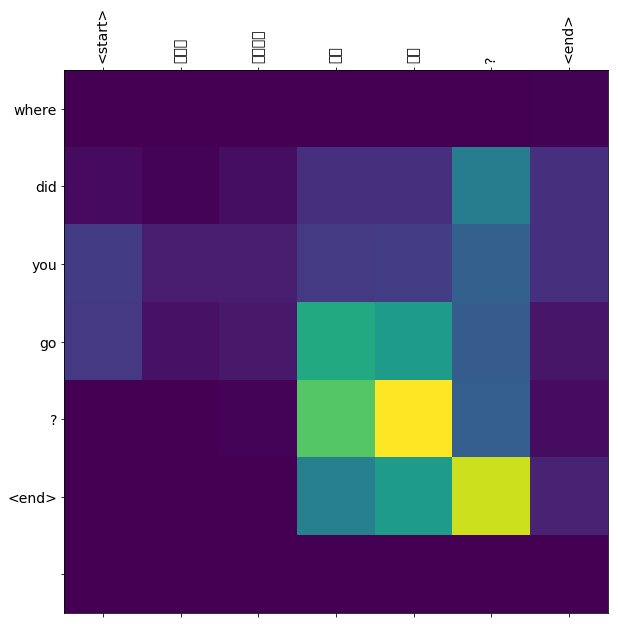

In [54]:
translate(u'तुम कहाँ गए थे?')

Input: <start> एक बार फिरसे कोशिश करो। <end>
Predicted translation: try it once again . <end> 


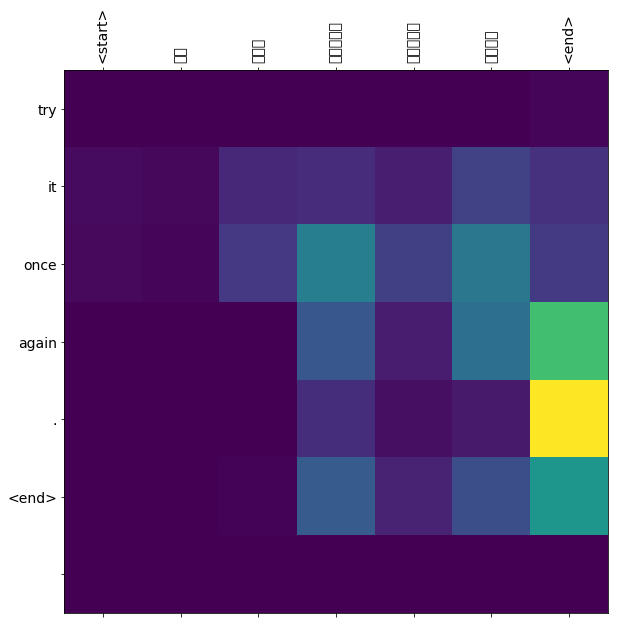

In [55]:
translate(u'एक बार फिरसे कोशिश करो।')

Input: <start> मुझे लिखना पसंद है <end>
Predicted translation: i can't put a koala ? <end> 


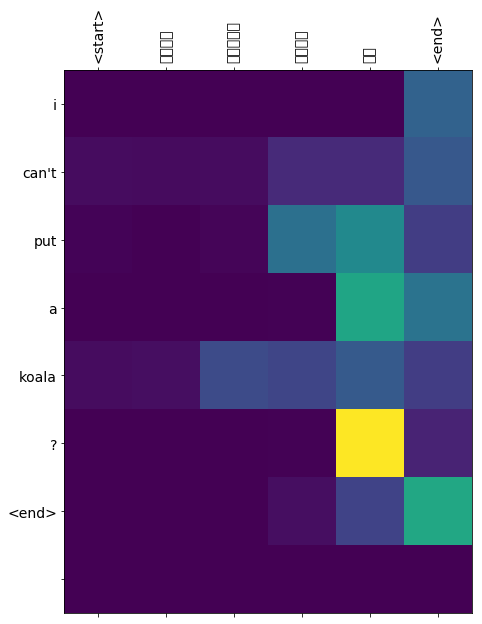

In [56]:
translate(u" मुझे लिखना पसंद है")

Input: <start> सब से अलग <end>
Predicted translation: please feed the wine . <end> 


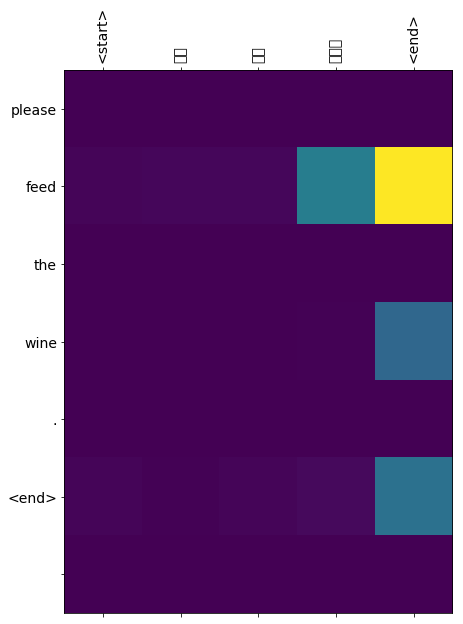

In [57]:
# wrong translation
translate(u'सब से अलग')

## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs
